#**Import Libraries**

In [100]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Layer, Input
from keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, Flatten, Dropout, Conv2DTranspose
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model, Sequential
from keras.layers import Concatenate, UpSampling2D
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

#**Mount Colab**

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
path = "/content/drive/MyDrive/Final_assing/Data/Semantic segmentation dataset"
listDir = []

for dir in os.listdir(path):
    if dir != "classes.json":
        listDir.append(dir)

listDir = sorted(listDir)




In [108]:
def loadImg(path, dirTile):
    input_img, mask_img = [], []
    dir_path = os.path.join(path, dirTile)

    inpDir, maskDir = os.listdir(dir_path)
    imgDirs = sorted(os.listdir(os.path.join(dir_path, inpDir)))
    mask_imgDirs = sorted(os.listdir(os.path.join(dir_path, maskDir)))

    for imgDir in imgDirs:
        imgPath = os.path.join(dir_path, inpDir, imgDir)
        img = load_img(imgPath, target_size=(224, 224))
        img = tf.convert_to_tensor(img, dtype=tf.float32) / 255.0
        input_img.append(img)

    for mask_imgDir in mask_imgDirs:
        maskPath = os.path.join(dir_path, maskDir, mask_imgDir)
        mask = load_img(maskPath, target_size=(224, 224))
        mask = tf.convert_to_tensor(mask, dtype=tf.float32) / 255.0
        mask_img.append(mask)

    return input_img, mask_img


In [109]:
def loadData(path, listDir):
    imgs_data, masks_data = [], []

    for dirTile in listDir:
        input_imgs, mask_imgs = loadImg(path, dirTile)

        imgs_data.extend(input_imgs)
        masks_data.extend(mask_imgs)

    return imgs_data, masks_data


In [110]:
input_imgs, mask_imgs = loadData(path, listDir)


In [112]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_masks, test_masks = train_test_split(input_imgs, mask_imgs,
                                                                  test_size = 0.2,
                                                                  shuffle = True,
                                                                  random_state = 42)

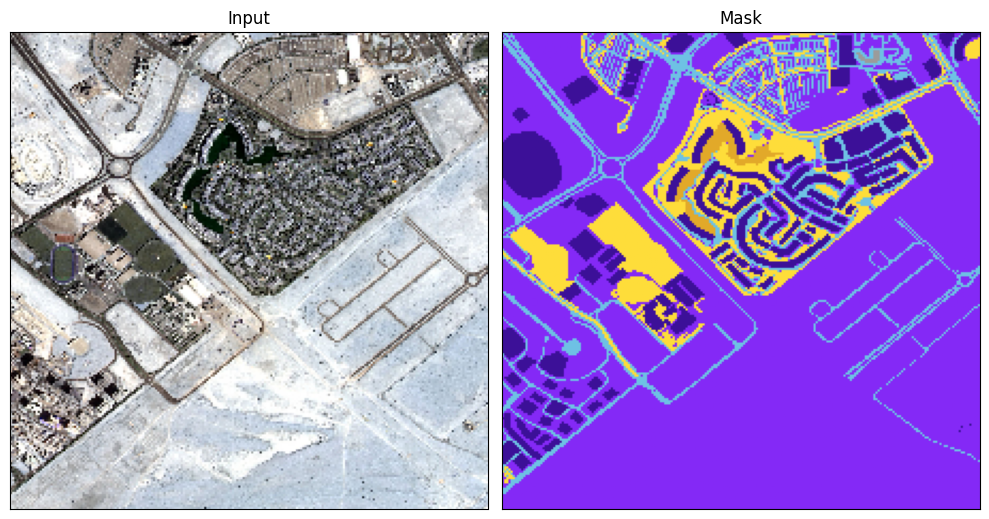

In [123]:

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(train_imgs[1])
plt.xticks([])
plt.yticks([])
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(train_masks[1])
plt.xticks([])
plt.yticks([])
plt.grid(True)


plt.tight_layout()
plt.show()


In [114]:
train_data = np.array(list(zip(train_imgs, train_masks)))
test_data = np.array(list(zip(test_imgs, test_masks)))

#**Define Attention Gate**

In [115]:
from tensorflow.keras.layers import Add, Activation, Multiply, Conv2D

def attention_gate(x, g, filters):
    theta_x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(filters, kernel_size=1, strides=1, padding='same')(g)
    add = Add()([theta_x, phi_g])
    act = Activation('relu')(add)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(act)
    sigmoid = Activation('sigmoid')(psi)
    attention = Multiply()([x, sigmoid])

    return attention


In [116]:

def Conv(x, dropout, filters):
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(dropout)(x)
    pool = MaxPooling2D(pool_size=(2, 2))(x)
    return x, pool


def UpSample(x, skip_connect, dropout, filters):
    x = UpSampling2D(size=(2, 2))(x)
    attention = attention_gate(skip_connect, x, filters)
    x = Concatenate(axis=-1)([attention, x])
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    return x


# **Define U-Net with attention**

In [117]:

def UNet(x, dropout, conv=[32, 64, 128, 256, 512]):
    # Encoder
    conv1, pool1 = Conv(x, dropout, conv[0])
    conv2, pool2 = Conv(pool1, dropout, conv[1])
    conv3, pool3 = Conv(pool2, dropout, conv[2])
    conv4, pool4 = Conv(pool3, dropout, conv[3])

    # Bottleneck
    conv5 = Conv2D(filters=conv[4], kernel_size=3, padding='same', activation='relu')(pool4)
    conv5 = Dropout(dropout)(conv5)
    conv5 = BatchNormalization()(conv5)

    # Decoder with attention
    conv6 = UpSample(conv5, conv4, dropout, conv[4])
    conv7 = UpSample(conv6, conv3, dropout, conv[3])
    conv8 = UpSample(conv7, conv2, dropout, conv[2])
    conv9 = UpSample(conv8, conv1, dropout, conv[1])

    # Output
    result = Conv2D(filters=3, kernel_size=1, padding='same', activation='sigmoid')(conv9)
    return result

In [118]:
input = Input(shape=(224, 224, 3))
output = UNet(input, dropout=0.1)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_104 (Conv2D)       │ (None, 224, 224, 32)   │            896 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 224, 224, 32)   │            128 │ conv2d_104[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_105 (Conv2D)       │ (None, 224, 224, 32)   │          9,248 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_38 (Dropout)      │ (None, 224, 224, 32)   │              0 │ conv2d_105[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 112, 112, 32)   │              0 │ dropout_38[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_106 (Conv2D)       │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 112, 112, 64)   │            256 │ conv2d_106[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_107 (Conv2D)       │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_39 (Dropout)      │ (None, 112, 112, 64)   │              0 │ conv2d_107[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 56, 56, 64)     │              0 │ dropout_39[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_108 (Conv2D)       │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_40    │ (None, 56, 56, 128)    │            512 │ conv2d_108[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_109 (Conv2D)       │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_40 (Dropout)      │ (None, 56, 56, 128)    │              0 │ conv2d_109[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 28, 28, 128)    │              0 │ dropout_40[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 11,581,223 (44.18 MB)

 Trainable params: 11,577,319 (44.16 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [119]:
# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





#**TRAIN**

In [120]:
history = model.fit(np.array(train_imgs), np.array(train_masks),
                    batch_size = 8,
                    epochs = 20,
                    validation_data = (np.array(test_imgs), np.array(test_masks)))

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.6470 - loss: 0.6595 - val_accuracy: 0.2524 - val_loss: 53.1471
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - accuracy: 0.8179 - loss: 0.5941 - val_accuracy: 0.2731 - val_loss: 64.1537
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - accuracy: 0.8810 - loss: 0.5601 - val_accuracy: 0.7524 - val_loss: 5.7836
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.8883 - loss: 0.5432 - val_accuracy: 0.7821 - val_loss: 0.7211
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.8476 - loss: 0.5513 - val_accuracy: 0.3706 - val_loss: 1.1219
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.8970 - loss: 0.5488 - val_accuracy: 0.7576 - val_loss: 0.6660
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.8859 - loss: 0.5438 - val_accuracy: 0.7375 - val_loss: 0.6186
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.8958 - loss: 0.5436 - val_accuracy: 0.7112 - val_loss

#**PLOT**

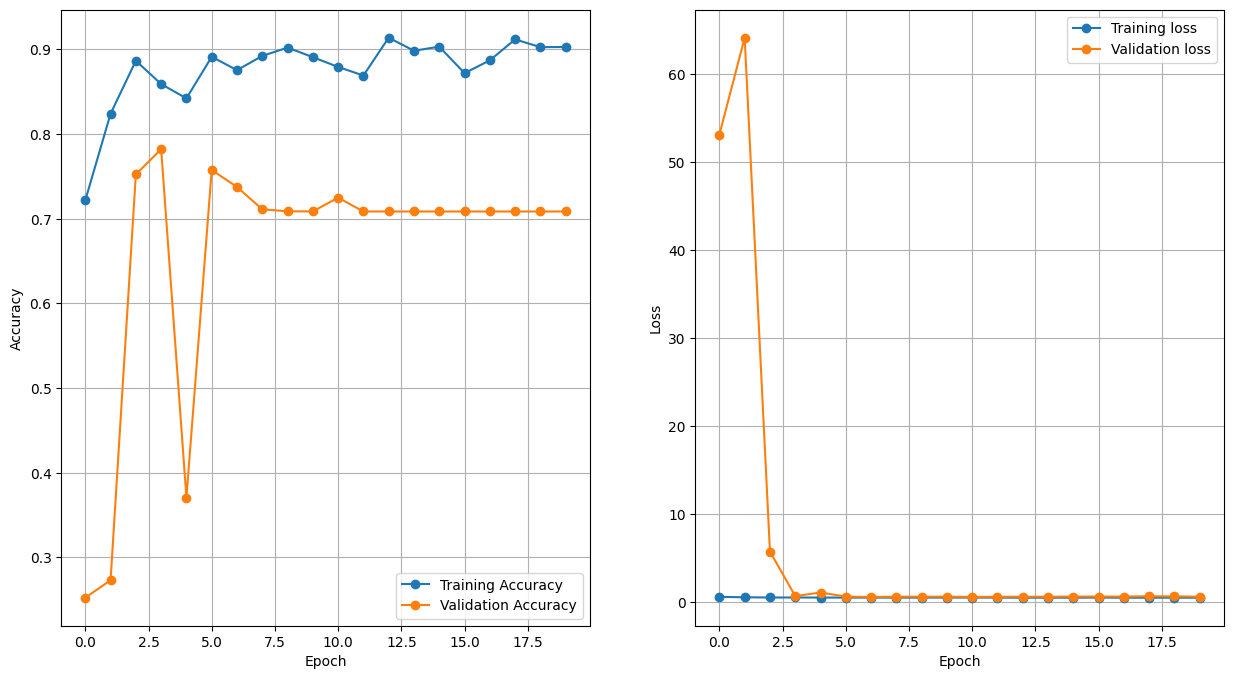

In [121]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='Training loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


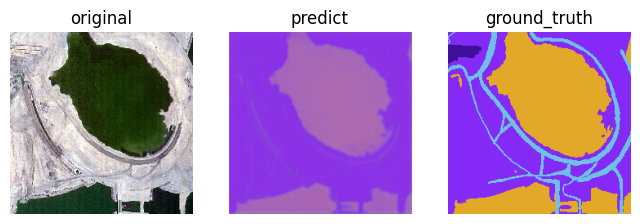

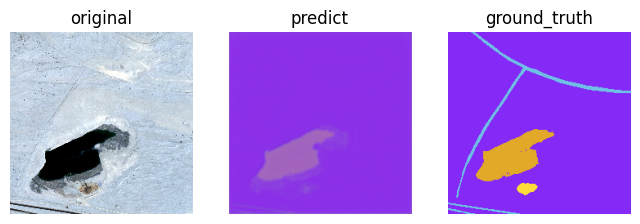

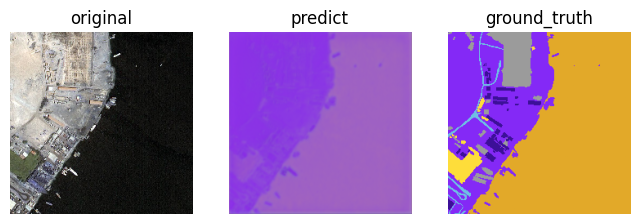

In [122]:
images_predict = model.predict(np.array(test_imgs))
def show_result(id):
    fig, ax = plt.subplots(1, 3, figsize = (8, 5))

    ax[0].set_title('original')
    ax[0].imshow(test_imgs[id])
    ax[0].axis("off")

    ax[1].set_title('predict')
    ax[1].imshow(images_predict[id])
    ax[1].axis("off")

    ax[2].set_title('ground_truth')
    ax[2].imshow(test_masks[id])
    ax[2].axis("off")

for id in range(3):
    show_result(id)